# Commodity Inflation Factor Return

Factor Returns using PCs from Breakeven and Inflation Curve

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CommodityInflationFactor\root\src")
from InflationFactorGenerator import FactorModel

## Factor Construction

Its assumed that factors with inflation premias with have $\beta$s toward said premias. This relationship can be exploited. Rather than defining a formalized model for inflation which is common in cross-sectional factor construction, a cheaper *back-of-the-enveloped* method can be used of creating a $\beta$-factor to a specific premia. <br>
<br>
Here are the steps for cross-sectional factors<br>
1. Get the fitted values of the first 3 PCs of the Breakeven and Inflation Swap Curve
2. Run a 30d rolling regression of those PCs against the returns of each commodity
3. Rank the $\beta$s and then quartile them only trading upper and lower quartile
4. Create dollar neutral baskets of each quartile in this case apply exponential weighting to the highest betas

In the main case the factor gets rebalanced daily. Most factor construction uses monthly rebalance, that will be investigated at the end of this notebook

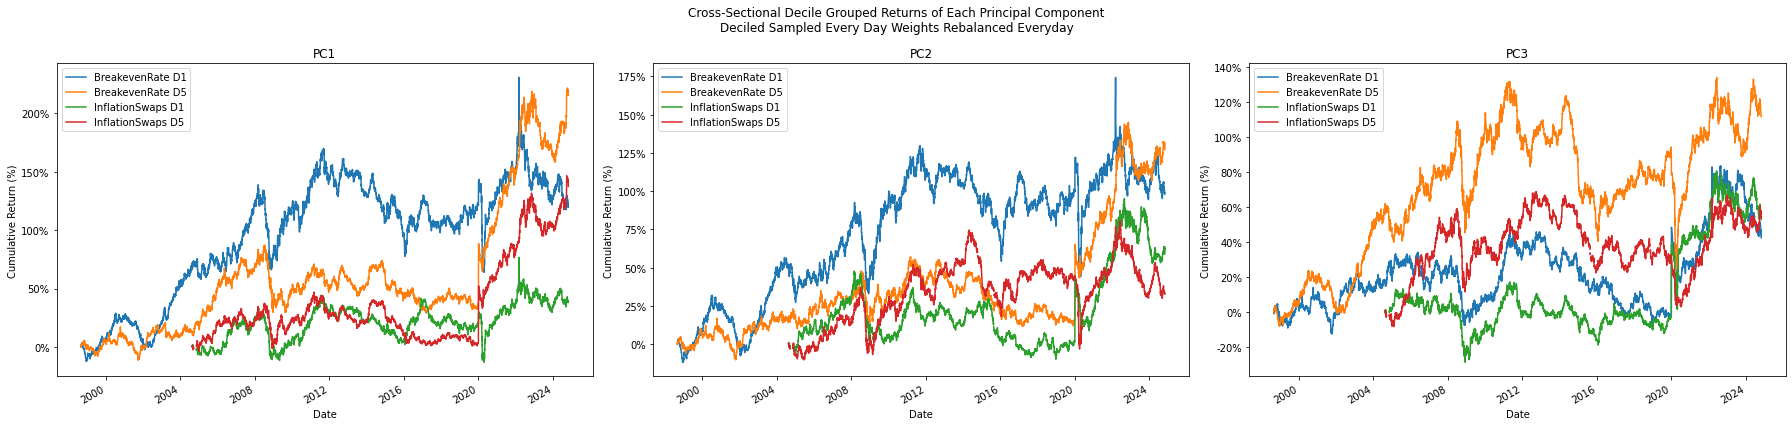

In [3]:
def plot_deciled_returns() -> plt.Figure:

    df_tmp = FactorModel().generate_factor()
    pcs = df_tmp.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(pcs), figsize = (25,6))

    for pc, ax in zip(pcs, axes.flatten()): 

        (df_tmp.query(
            "variable == @pc").
            assign(
                name = lambda x: x.name + " " + x.lag_decile.astype(str),
                factor_rtn = lambda x: np.where(x.lag_decile == "D1", -1 * x.factor_rtn, x.factor_rtn))
            [["name", "date", "factor_rtn"]].
            groupby(["name", "date"]).
            agg("sum").
            reset_index().
            rename(columns = {"name": ""}).
            pivot(index = "date", columns = "", values = "factor_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = pc,
                ylabel = "Cumulative Return (%)",
                xlabel = "Date"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    fig.suptitle("Cross-Sectional Decile Grouped Returns of Each Principal Component\nDeciled Sampled Every Day Weights Rebalanced Everyday")
    plt.tight_layout()
    
plot_deciled_returns()

In [4]:
def get_daily_sharpe() -> pd.DataFrame: 
    
    df_tmp = FactorModel().generate_factor()
    df_sharpe = (df_tmp.assign(
        group_var = lambda x: x.group_var + " " + x.lag_decile.astype(str))
        [["group_var", "factor_rtn", "date"]].
        groupby(["date", "group_var"]).
        agg("sum").
        reset_index().
        drop(columns = ["date"]).
        groupby("group_var").
        agg(["mean", "std"])
        ["factor_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        assign(
            inflation_group = lambda x: x.group_var.str.split(" ").str[0],
            pc              = lambda x: x.group_var.str.split(" ").str[1],
            decile          = lambda x: x.group_var.str.split(" ").str[2]))
    
    return df_sharpe

df_sharpe = get_daily_sharpe()

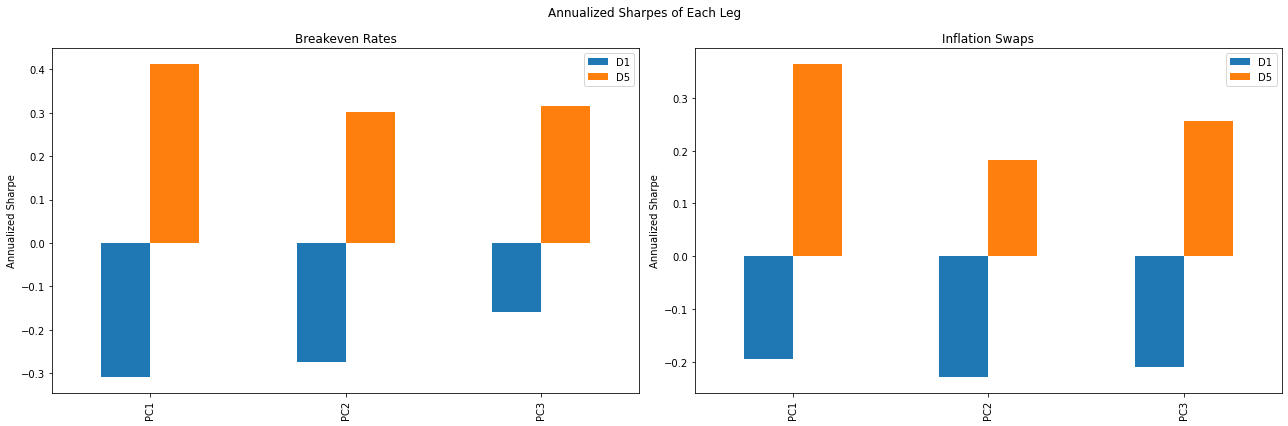

In [5]:
def plot_daily_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure:     
    
    inflation_groups = df_sharpe.inflation_group.drop_duplicates().sort_values().to_list()
    fig, axes        = plt.subplots(ncols = len(inflation_groups), figsize = (18,6))

    renamer = {
        "BreakevenRate": "Breakeven Rates",
        "InflationSwaps": "Inflation Swaps"}

    for inflation_group, ax in zip(inflation_groups, axes.flatten()):

        (df_sharpe.query(
            "inflation_group == @inflation_group")
            [["pc", "decile", "sharpe"]].
            rename(columns = {"decile": ""}).
            pivot(index = "pc", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                ylabel = "Annualized Sharpe",
                title  = renamer[inflation_group]))

    fig.suptitle("Annualized Sharpes of Each Leg")
    plt.tight_layout()
    
plot_daily_sharpe(df_sharpe)

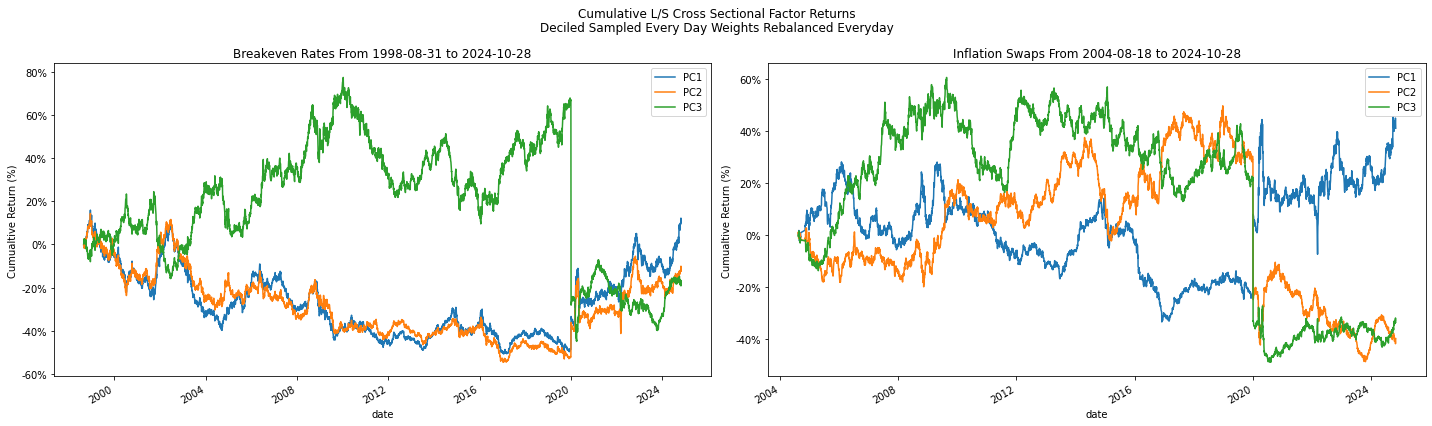

In [6]:
def plot_factor_rtn() -> plt.Figure: 
    
    df_tmp = (FactorModel().generate_factor_rtn().assign(
        inflation_group = lambda x: x.group_var.str.split(" ").str[0],
        pc              = lambda x: x.group_var.str.split(" ").str[1]).
        drop(columns = ["group_var"]))

    inflation_groups = df_tmp.inflation_group.drop_duplicates().to_list()
    fig, axes        = plt.subplots(ncols = len(inflation_groups), figsize = (20,6))

    renamer = {
        "BreakevenRate": "Breakeven Rates",
        "InflationSwaps": "Inflation Swaps"}

    for inflation_group, ax in zip(inflation_groups, axes.flatten()):

        df_plot = (df_tmp.query(
            "inflation_group == @inflation_group").
            drop(columns = ["inflation_group"]).
            rename(columns = {"pc": ""}).
            pivot(index = "date", columns = "", values = "factor_rtn"))

        (df_plot.apply(
            lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax = ax,
                ylabel = "Cumualtive Return (%)",
                title = "{} From {} to {}".format(
                    renamer[inflation_group],
                    df_plot.index.min().date(),
                    df_plot.index.max().date())))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
        
    fig.suptitle("Cumulative L/S Cross Sectional Factor Returns\nDeciled Sampled Every Day Weights Rebalanced Everyday")
    plt.tight_layout()
    
plot_factor_rtn()

The graph implies most implies that being short the factor makes money. In this case that means long commodities with negative inflation betas and short the ones that are. The 3rd PC will be avoided since its contribution to the cumulative explained varaince is negligable. 

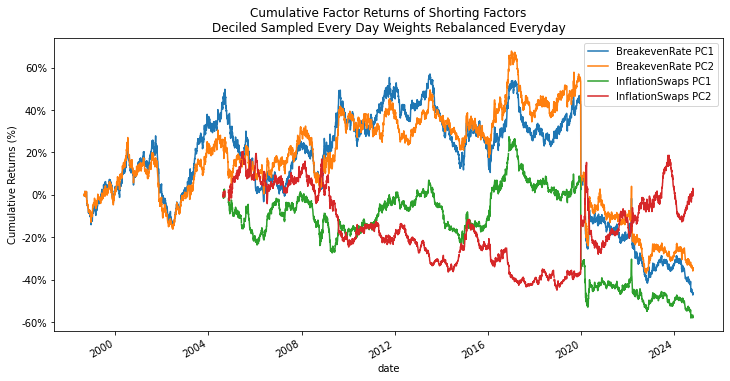

In [7]:
def plot_short_factors() -> plt.Figure: 
    
    df_tmp = FactorModel().generate_factor()
    fig, axes = plt.subplots(figsize = (12,6))

    (df_tmp.assign(
        factor_rtn = lambda x: -1 * x.factor_rtn).
        query("variable != 'PC3'")
        [["date", "group_var", "factor_rtn"]].
        groupby(["date", "group_var"]).
        agg("sum").
        reset_index().
        rename(columns = {"group_var": ""}).
        pivot(index = "date", columns = "", values = "factor_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes,
            ylabel = "Cumulative Returns (%)",
            title  = "Cumulative Factor Returns of Shorting Factors\nDeciled Sampled Every Day Weights Rebalanced Everyday"))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    
plot_short_factors()

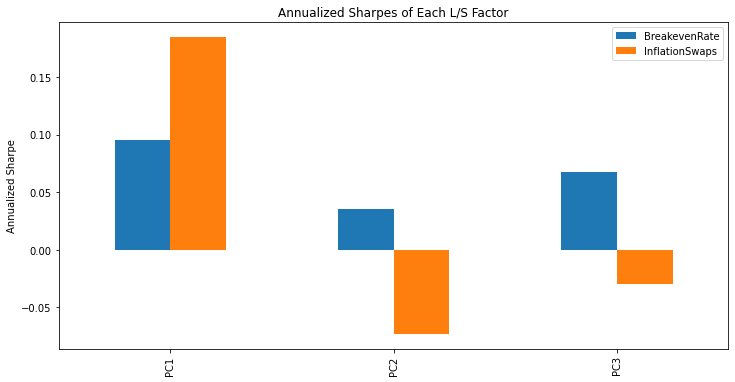

In [8]:
def plot_daily_sharpe() -> plt.Figure: 
    
    (FactorModel().generate_factor_rtn().drop(
        columns = ["date"]).
        groupby("group_var").
        agg(["mean", "std"])
        ["factor_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        assign(
            inflation_group = lambda x: x.group_var.str.split(" ").str[0],
            pcs             = lambda x: x.group_var.str.split(" ").str[1])
        [["inflation_group", "pcs", "sharpe"]].
        rename(columns = {"inflation_group": ""}).
        pivot(index = "pcs", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpes of Each L/S Factor",
            figsize = (12,6)))
    
plot_daily_sharpe()

## Monthly Rebalance Factors

Try rebalancing monthly rather than daily. 

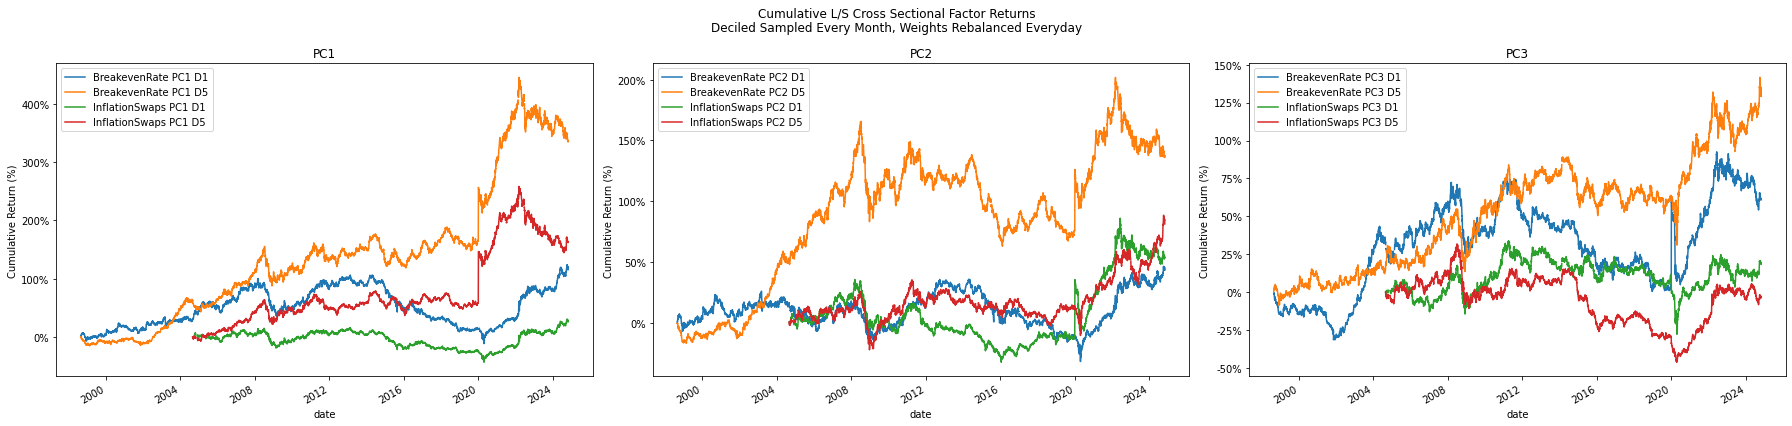

In [9]:
def plot_monthly_legs() -> plt.Figure: 
    
    df_tmp = (FactorModel().generate_monthly_factor().assign(
        inflation_group = lambda x: x.group_var.str.split(" ").str[0],
        pc              = lambda x: x.group_var.str.split(" ").str[1]))

    pcs       = df_tmp.pc.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(pcs), figsize = (25,6))

    for pc, ax in zip(pcs, axes.flatten()): 

        (df_tmp.query(
            "pc == @pc").
            assign(
                factor_rtn = lambda x: np.where(x.lag_decile == "D5", x.factor_rtn, -x.factor_rtn),
                group_var  = lambda x: x.group_var + " " + x.lag_decile.astype(str))
            [["group_var", "date", "factor_rtn"]].
            groupby(["date", "group_var"]).
            agg("sum").
            reset_index().
            rename(columns = {"group_var": ""}).
            pivot(index = "date", columns = "", values = "factor_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                ylabel = "Cumulative Return (%)",
                title  = pc))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    fig.suptitle("Cumulative L/S Cross Sectional Factor Returns\nDeciled Sampled Every Month, Weights Rebalanced Everyday")
    plt.tight_layout()
    
plot_monthly_legs()

In [10]:
def get_monthly_sharpe() -> pd.DataFrame: 
    
    df_tmp = (FactorModel().generate_monthly_factor().assign(
        group_var = lambda x: x.group_var + " " + x.lag_decile.astype(str))
        [["date", "group_var", "factor_rtn"]].
        groupby(["date", "group_var"]).
        agg("sum").
        reset_index().
        drop(columns = ["date"]).
        groupby("group_var").
        agg(["mean", "std"])
        ["factor_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        assign(
           inflation_group = lambda x: x.group_var.str.split(" ").str[0],
           pc              = lambda x: x.group_var.str.split(" ").str[1],
           decile          = lambda x: x.group_var.str.split(" ").str[2]))
    
    return df_tmp

df_monthly_sharpe = get_monthly_sharpe()

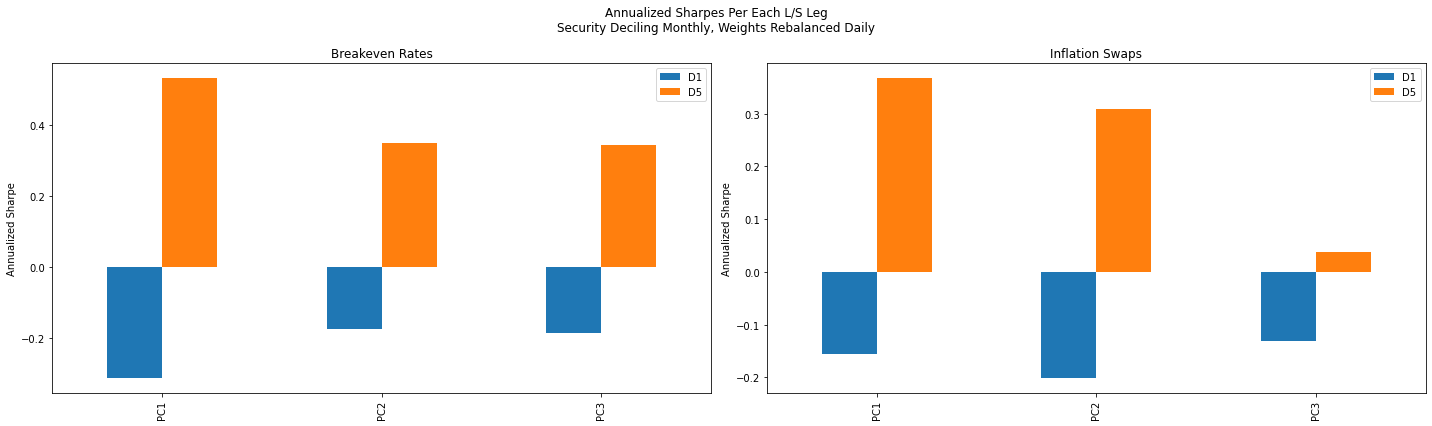

In [11]:
def plot_monthly_sharpe(df_monthly_sharpe: pd.DataFrame) -> plt.Figure: 
    
    inflation_groups = df_monthly_sharpe.inflation_group.drop_duplicates().sort_values().to_list()
    fig, axes        = plt.subplots(ncols = len(inflation_groups), figsize = (20,6))

    renamer = {
        "BreakevenRate": "Breakeven Rates",
        "InflationSwaps": "Inflation Swaps"}

    for inflation_group, ax in zip(inflation_groups, axes.flatten()):

        (df_monthly_sharpe.query(
            "inflation_group == @inflation_group")
            [["pc", "decile", "sharpe"]].
            rename(columns = {"decile": ""}).
            pivot(index = "pc", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                ylabel = "Annualized Sharpe",
                xlabel = "",
                title  = renamer[inflation_group]))

    fig.suptitle("Annualized Sharpes Per Each L/S Leg\nSecurity Deciling Monthly, Weights Rebalanced Daily")
    plt.tight_layout()
    
plot_monthly_sharpe(df_monthly_sharpe)

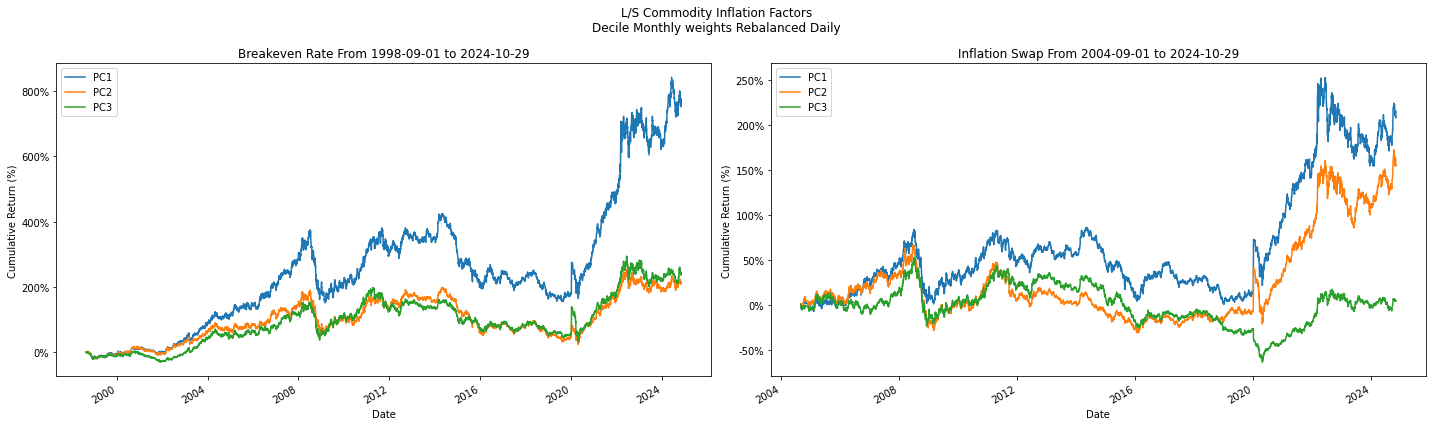

In [12]:
def plot_monthly_factor_performance() -> plt.Figure: 
    
    df_tmp = FactorModel().generate_monthly_factor_rtn()

    inflation_groups = df_tmp.inflation_group.drop_duplicates().sort_values().to_list()
    fig, axes        = plt.subplots(ncols = len(inflation_groups), figsize = (20,6))

    renamer = {
        "BreakevenRate" : "Breakeven Rate",
        "InflationSwaps": "Inflation Swap"}

    for inflation_group, ax in zip(inflation_groups, axes.flatten()):

        df_plot = (df_tmp.query(
            "inflation_group == @inflation_group")
            [["pc", "date", "spread"]].
            rename(columns = {"pc": ""}).
            pivot(index = "date", columns = "", values = "spread").
            apply(lambda x: np.cumprod(1 + x) - 1))

        (df_plot.plot(
            ax     = ax,
            ylabel = "Cumulative Return (%)",
            xlabel = "Date",
            title  = "{} From {} to {}".format(
                renamer[inflation_group],
                df_plot.index.min().date(),
                df_plot.index.max().date())))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
        
    fig.suptitle("L/S Commodity Inflation Factors\nDecile Monthly weights Rebalanced Daily")
    plt.tight_layout()
    
plot_monthly_factor_performance()

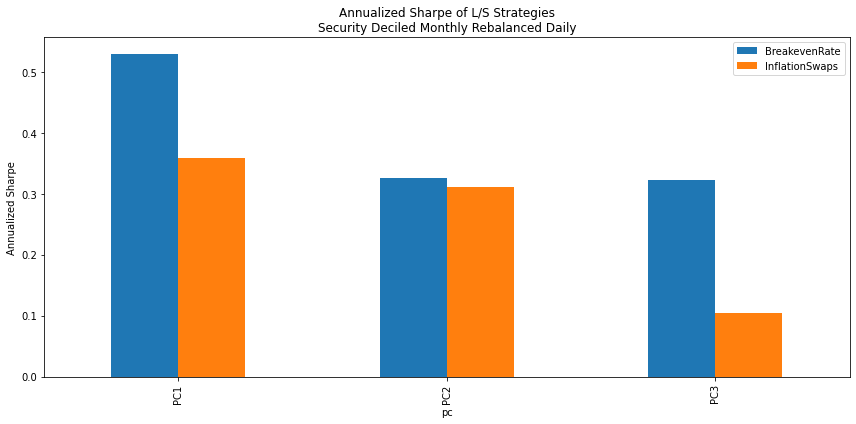

In [13]:
def plot_monthly_factor_sharpe() -> plt.Figure: 
    
    (FactorModel().generate_monthly_factor_rtn()[
        ["group_var", "spread"]].
        groupby("group_var").
        agg(["mean", "std"])
        ["spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        assign(
            inflation_group = lambda x: x.group_var.str.split(" ").str[0],
            pc              = lambda x: x.group_var.str.split(" ").str[1])
        [["inflation_group", "pc", "sharpe"]].
        rename(columns = {"inflation_group": ""}).
        pivot(index = "pc", columns = "", values = "sharpe").
        plot(
            figsize = (12,6),
            kind    = "bar",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe of L/S Strategies\nSecurity Deciled Monthly Rebalanced Daily"))

    plt.tight_layout()
    
plot_monthly_factor_sharpe()